In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, GRU, LSTM, Bidirectional,Reshape
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam, RMSprop 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model
from torch.utils.data import DataLoader, Dataset
import cv2 as cv
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [46]:
df = pd.read_csv('./preprocessed-dataset-meta-file.csv')

In [47]:
data_path = './dataset'

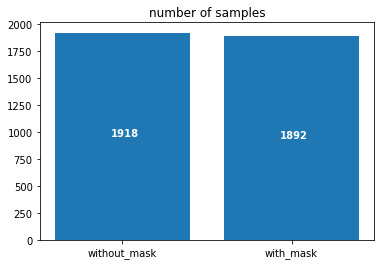

In [48]:
counts = df['label'].value_counts().to_dict()
plt.bar(counts.keys(), counts.values())
plt.title('number of samples')
for i, val in enumerate(counts.values()):
    plt.text(i - 0.07, val / 2, f'{val}', color = 'white', fontweight = 'bold')
# End For
plt.show()

In [49]:
classes_dict = {'without_mask': 0, 'with_mask': 1}
def encode_label(label):
    return classes_dict[label]
# End Func

In [50]:
tic = time.time()
X, y = [], []
for i, img_path in enumerate(df['img_path'].values):
    img = cv.imread(img_path, 1)
    lbl = df['label'].values[i]
    X.append(img)
    y.append(encode_label(lbl))
# End For
X = np.array(X)
y = np.array(y)
toc = time.time()
print(f'Loading Time: {toc - tic} seconds')

Loading Time: 6.479979515075684 seconds


In [51]:
if len(X.shape) == 3:
    X = X.reshape(-1, X.shape[1], X.shape[2], 1)
# End If
X.shape

(3810, 96, 96, 3)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, stratify=y, random_state=42)

In [53]:
class ConvBlock:
    def __init__(self, out_dims, batch_norm = False):
        self.out_dims = out_dims
        self.batch_norm = batch_norm
    # End Func
    
    def __call__(self, input_layer):
        out = Conv2D(self.out_dims[0], (3, 3),padding='same', activation='linear')(input_layer)
        out = Conv2D(
            self.out_dims[1], (3, 3), 
            kernel_regularizer=regularizers.l2(0.001),
            padding='valid', 
            activation='elu'
        )(out)
        if self.batch_norm == True:
            out = BatchNormalization()(out)
        # End If
        out = Dropout(0.15)(out)
        out = MaxPooling2D(pool_size=(2, 2))(out)
        return out
    # End Func
# End Class

def ConvNet(input_shape = (96,96,3)):
    input_layer = Input(shape = input_shape)
    out = ConvBlock(out_dims = [3, 16])(input_layer)
    out = Flatten()(out)
    out = Dense(256, activation='relu')(out)
    out = Dropout(0.15)(out)
    output_layer = Dense(1, activation='sigmoid')(out)
    return Model(input_layer, output_layer)
# End Func

In [54]:
model = ConvNet(input_shape = (96,96,3))
print(model.summary())

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 96, 96, 3)         84        
                                                                 
 conv2d_15 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 dropout_14 (Dropout)        (None, 94, 94, 16)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 47, 47, 16)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 35344)             0         
                                                           

In [55]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9)
rmsprp_opt = tensorflow.keras.optimizers.RMSprop(lr=0.00003 ,decay=1e-4)
adam=tensorflow.keras.optimizers.Adam(lr=0.0002)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
checkpoint = ModelCheckpoint(filepath='bestmodel.hdf5', verbose=1,monitor='val_accuracy',save_best_only=True,save_weights_only=False)

H1=model.fit(
    X_train, y_train,
    batch_size = 100, epochs=10,
    verbose=1,
    callbacks = [checkpoint],
    validation_data=(X_test, y_test)
)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
35/35 [==============================] - ETA: 0s - loss: 30.2718 - accuracy: 0.7031WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000023D1E431048> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model Evaluation
Accuracy Score: 93.96%
Precision Score: 94.01%
Recall Score: 93.98%
F1 Score: 93.96%
Classification Report: 
               precision    recall  f1-score   support

without_mask       0.96      0.92      0.94       192
   with_mask       0.92      0.96      0.94       189

    accuracy                           0.94       381
   macro avg       0.94      0.94

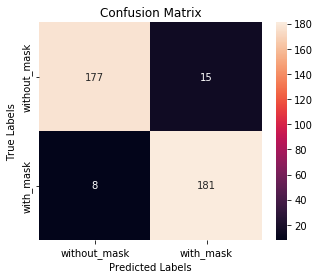

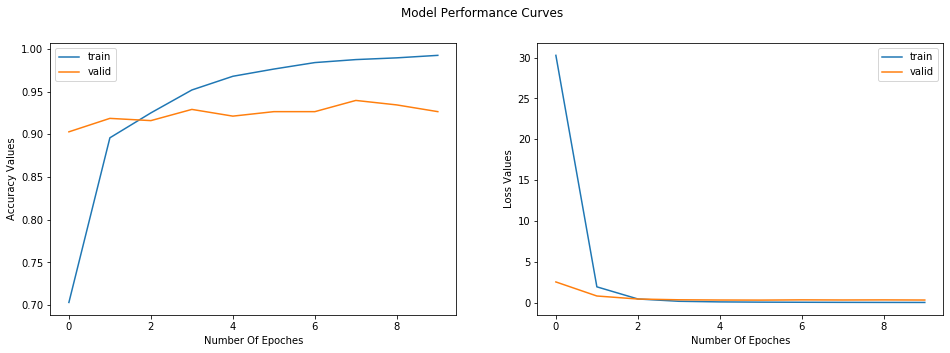

In [67]:
model_t = load_model('model/bestmodel-93.hdf5')
y_predict = (model_t.predict(X_test) > 0.5).ravel().astype(np.int8)
evaluate_model(y_true = y_test, y_predict = y_predict, cls_names=classes_dict.keys())
plt_learning_curves(H1.history)